In [5]:
import torch

def one_hot_encode(labels, attribute_groups):
    """
    Converts group-wise labels into one-hot encoded vectors.

    Args:
        labels (dict): Dictionary of labels for each attribute group, e.g.,
                       {"has_bill_shape": [2, 1], "has_wing_color": [9, 15], ...}.
        attribute_groups (dict): Dictionary where keys are group names, and values are the list of indices
                                 representing the possible attributes in each group.
    
    Returns:
        dict: A dictionary of one-hot encoded tensors for each attribute group.
    """
    one_hot_labels = {}
    for group_name, indices in attribute_groups.items():
        num_classes = len(indices)  # Total possible classes in the group
        group_labels = labels[group_name]  # Labels for this group (tensor of indices)
        
        # Initialize one-hot tensor with shape [batch_size, num_classes]
        one_hot = torch.zeros((len(group_labels), num_classes), dtype=torch.float32)
        
        # Fill the correct indices with 1
        one_hot.scatter_(1, group_labels.unsqueeze(1), 1)
        
        one_hot_labels[group_name] = one_hot
    return one_hot_labels


In [22]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import glob

class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, image_size=(224, 224)):
        """
        Dataset to handle images and their grouped attribute labels.
        """
        self.image_paths = self.get_image_paths(image_dir)
        self.labels = self.load_labels(label_file, attribute_groups)
        self.attribute_groups = attribute_groups
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
    # Load the image and preprocess
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Prepare labels
        labels = {group: self.labels[idx, min(indices):max(indices)+1].argmax().item()
              for group, indices in self.attribute_groups.items()}

        return image, labels


    def get_image_paths(self, image_dir):
        image_paths = glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True)
        return sorted(image_paths)

    @staticmethod
    def load_labels(label_file, attribute_groups):
        """
        Load and group labels from the label file.
        """
        with open(label_file, 'r') as file:
            labels = [list(map(int, line.strip().split())) for line in file]
        
        grouped_labels = [
            {group_name: max([line[idx] for idx in indices])
             for group_name, indices in attribute_groups.items()}
            for line in labels
        ]
        return grouped_labels

    @staticmethod
    def one_hot_encode(labels, attribute_groups):
        """
        Convert raw labels into one-hot encoded vectors for each attribute group.
        """
        one_hot_labels = {}
        for group_name, indices in attribute_groups.items():
            num_classes = len(indices)
            group_label = labels[group_name]  # Integer label for this group
            
            # Initialize a one-hot tensor
            one_hot = torch.zeros(num_classes, dtype=torch.float32)
            one_hot[group_label] = 1.0  # Set the correct index to 1
            
            one_hot_labels[group_name] = one_hot
        return one_hot_labels


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define a new model architecture
class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        
        # Save the in_features of the original fully connected layer
        in_features = self.resnet.fc.in_features
        
        # Replace the final fully connected layer with Identity
        self.resnet.fc = nn.Identity()
        
        # Create a separate classifier for each attribute group
        self.group_classifiers = nn.ModuleDict({
            group_name: nn.Sequential(
                nn.Linear(in_features, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, len(indices))  # No activation here; BCEWithLogitsLoss handles it
            )
            for group_name, indices in attribute_groups.items()
        })
    
    def forward(self, x):
        features = self.resnet(x)  # Extract features using ResNet backbone
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.group_classifiers.items()
        }
        return outputs

# Define your attribute groups as provided
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54, 58)),
    "has_back_color": list(range(58, 73)),
    "has_tail_shape": list(range(73, 79)),
    "has_upper_tail_color": list(range(79, 94)),
    "has_head_pattern": list(range(94, 105)),
    "has_breast_color": list(range(105, 120)),
    "has_throat_color": list(range(120, 135)),
    "has_eye_color": list(range(135, 149)),
    "has_bill_length": list(range(149, 152)),
    "has_forehead_color": list(range(152, 167)),
    "has_under_tail_color": list(range(167, 182)),
    "has_nape_color": list(range(182, 197)),
    "has_belly_color": list(range(197, 212)),
    "has_wing_shape": list(range(212, 217)),
    "has_size": list(range(217, 222)),
    "has_shape": list(range(222, 236)),
    "has_back_pattern": list(range(236, 240)),
    "has_tail_pattern": list(range(240, 244)),
    "has_belly_pattern": list(range(244, 248)),
    "has_primary_color": list(range(248, 263)),
    "has_leg_color": list(range(263, 278)),
    "has_bill_color": list(range(278, 293)),
    "has_crown_color": list(range(293, 308)),
    "has_wing_pattern": list(range(308, 312)),
}

# Paths to data
train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"

# Hyperparameters
n_labels = 312
batch_size = 32
epochs = 1
learning_rate = 0.001
# Prepare datasets and dataloaders
image_size = (224, 224)  # Required input size for ResNet
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, image_size)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, image_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = ResNetGroupedMultiClass(attribute_groups).to(device)
criterion = {group: nn.BCEWithLogitsLoss() for group in attribute_groups.keys()}
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Example: Access one batch
for images, labels in train_loader:
    print("Images shape:", images.shape)  # Should be [batch_size, 3, image_size, image_size]
    print("One-hot Labels:")
    for group_name, group_labels in labels.items():
        print(f"{group_name}: {group_labels.shape}")  # [batch_size, num_classes]
    break


Images shape: torch.Size([32, 3, 224, 224])
One-hot Labels:
has_bill_shape: torch.Size([32, 9])
has_wing_color: torch.Size([32, 15])
has_upperparts_color: torch.Size([32, 15])
has_underparts_color: torch.Size([32, 15])
has_breast_pattern: torch.Size([32, 4])
has_back_color: torch.Size([32, 15])
has_tail_shape: torch.Size([32, 6])
has_upper_tail_color: torch.Size([32, 15])
has_head_pattern: torch.Size([32, 11])
has_breast_color: torch.Size([32, 15])
has_throat_color: torch.Size([32, 15])
has_eye_color: torch.Size([32, 14])
has_bill_length: torch.Size([32, 3])
has_forehead_color: torch.Size([32, 15])
has_under_tail_color: torch.Size([32, 15])
has_nape_color: torch.Size([32, 15])
has_belly_color: torch.Size([32, 15])
has_wing_shape: torch.Size([32, 5])
has_size: torch.Size([32, 5])
has_shape: torch.Size([32, 14])
has_back_pattern: torch.Size([32, 4])
has_tail_pattern: torch.Size([32, 4])
has_belly_pattern: torch.Size([32, 4])
has_primary_color: torch.Size([32, 15])
has_leg_color: torch.Si

In [30]:
for images, labels in train_loader:
    print("Images shape:", images.shape)  # Should be [batch_size, 3, image_size, image_size]
    print("One-hot Labels:")
    for group_name, group_labels in labels.items():
        print(f"{group_name}: {group_labels}")  # [batch_size, num_classes]
    break

Images shape: torch.Size([32, 3, 224, 224])
One-hot Labels:
has_bill_shape: tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
    

In [24]:

def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    """
    Trains the grouped model on the training dataset.
    
    Parameters:
        model: The model to train.
        train_loader: DataLoader for the training dataset.
        criterion: Dictionary of loss functions for each group.
        optimizer: Optimizer for the model.
        epochs: Number of epochs to train.
    
    Returns:
        None. Prints the loss and accuracy for each epoch.
    """
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        
        # Variables to calculate total accuracy for this epoch
        total_correct = 0
        total_attributes = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            
            optimizer.zero_grad()
            outputs = model(images)

            predictions = {group: torch.argmax(output, dim=1) for group, output in outputs.items()}

            # Compute loss for each group and aggregate
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Update accuracy metrics
            for group in outputs:
                preds = (torch.sigmoid(outputs[group]) > 0.5).float()
                total_correct += (preds == labels[group]).sum().item()
                total_attributes += labels[group].numel()
        
        # Calculate and print metrics for the epoch
        epoch_accuracy = total_correct / total_attributes
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")



def evaluate_grouped_model(model, test_loader, criterion):
    """
    Evaluates the grouped model on the test dataset.
    
    Parameters:
        model: The trained model.
        test_loader: DataLoader for the test dataset.
        criterion: Dictionary of loss functions for each group.
    
    Returns:
        None. Prints the loss and accuracy for each group and the total accuracy.
    """
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}
    
    # Variables to calculate total accuracy
    total_correct = 0
    total_attributes = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()
                
                # Get predictions and calculate group-wise accuracy
                preds = (torch.sigmoid(outputs[group]) > 0.5).float()
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].numel()
                
                # Update total accuracy metrics
                total_correct += (preds == labels[group]).sum().item()
                total_attributes += labels[group].numel()
    
    # Print group-wise metrics
    for group in attribute_groups.keys():
        accuracy = correct_predictions[group] / total_samples[group]
        print(f"Group: {group}, Accuracy: {accuracy:.4f}")
    
    # Print total loss and total accuracy
    print(f"Total Loss: {total_loss / len(test_loader):.4f}")
    total_accuracy = total_correct / total_attributes
    print(f"Total Accuracy: {total_accuracy:.4f}")

                
    


In [25]:
train_grouped_model(model, train_loader, criterion, optimizer, epochs=1)

Epoch 1/1, Loss: 2.5589, Accuracy: 0.9760


In [26]:
evaluate_grouped_model(model, test_loader, criterion)

Group: has_bill_shape, Accuracy: 0.9952
Group: has_wing_color, Accuracy: 0.9898
Group: has_upperparts_color, Accuracy: 0.9829
Group: has_underparts_color, Accuracy: 0.9871
Group: has_breast_pattern, Accuracy: 0.9543
Group: has_back_color, Accuracy: 0.9709
Group: has_tail_shape, Accuracy: 0.9305
Group: has_upper_tail_color, Accuracy: 0.9554
Group: has_head_pattern, Accuracy: 0.9937
Group: has_breast_color, Accuracy: 0.9890
Group: has_throat_color, Accuracy: 0.9937
Group: has_eye_color, Accuracy: 0.9934
Group: has_bill_length, Accuracy: 0.9854
Group: has_forehead_color, Accuracy: 0.9936
Group: has_under_tail_color, Accuracy: 0.9666
Group: has_nape_color, Accuracy: 0.9902
Group: has_belly_color, Accuracy: 0.9850
Group: has_wing_shape, Accuracy: 0.8584
Group: has_size, Accuracy: 1.0000
Group: has_shape, Accuracy: 1.0000
Group: has_back_pattern, Accuracy: 0.8901
Group: has_tail_pattern, Accuracy: 0.8801
Group: has_belly_pattern, Accuracy: 0.9405
Group: has_primary_color, Accuracy: 1.0000
Gr

In [27]:
def visualize_predictions(model, dataloader, attribute_groups, num_samples=5):
    """
    Visualizes predictions and actual labels along with the images.
    
    Parameters:
        model: The trained model.
        dataloader: DataLoader object for the dataset.
        attribute_groups: Dictionary defining attribute groups and indices.
        num_samples: Number of samples to visualize.
    """
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return
                
                # Get predictions and actual labels for each group
                predictions = {
                    group: (torch.sigmoid(outputs[group][i]) > 0.5).cpu().numpy()
                    for group in attribute_groups.keys()
                }
                actuals = {
                    group: labels[group][i].cpu().numpy()
                    for group in attribute_groups.keys()
                }
                
                # Plot the image
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image - image.min()) / (image.max() - image.min())  # Normalize for display
                
                plt.figure(figsize=(12, 8))
                plt.imshow(image)
                plt.axis('off')
                plt.title("Image")
                
                # Display predictions and actual labels
                group_text = ""
                for group in attribute_groups.keys():
                    pred_str = ", ".join([
                        str(attr) for attr, val in zip(attribute_groups[group], predictions[group]) if val == 1
                    ])
                    actual_str = ", ".join([
                        str(attr) for attr, val in zip(attribute_groups[group], actuals[group]) if val == 1
                    ])
                    group_text += f"**{group}**\nPredicted: {pred_str}\nActual: {actual_str}\n\n"
                
                # Add text annotations
                plt.gcf().text(0.1, -0.15, group_text, fontsize=10, wrap=True)
                plt.tight_layout()
                plt.show()
                
                samples_shown += 1


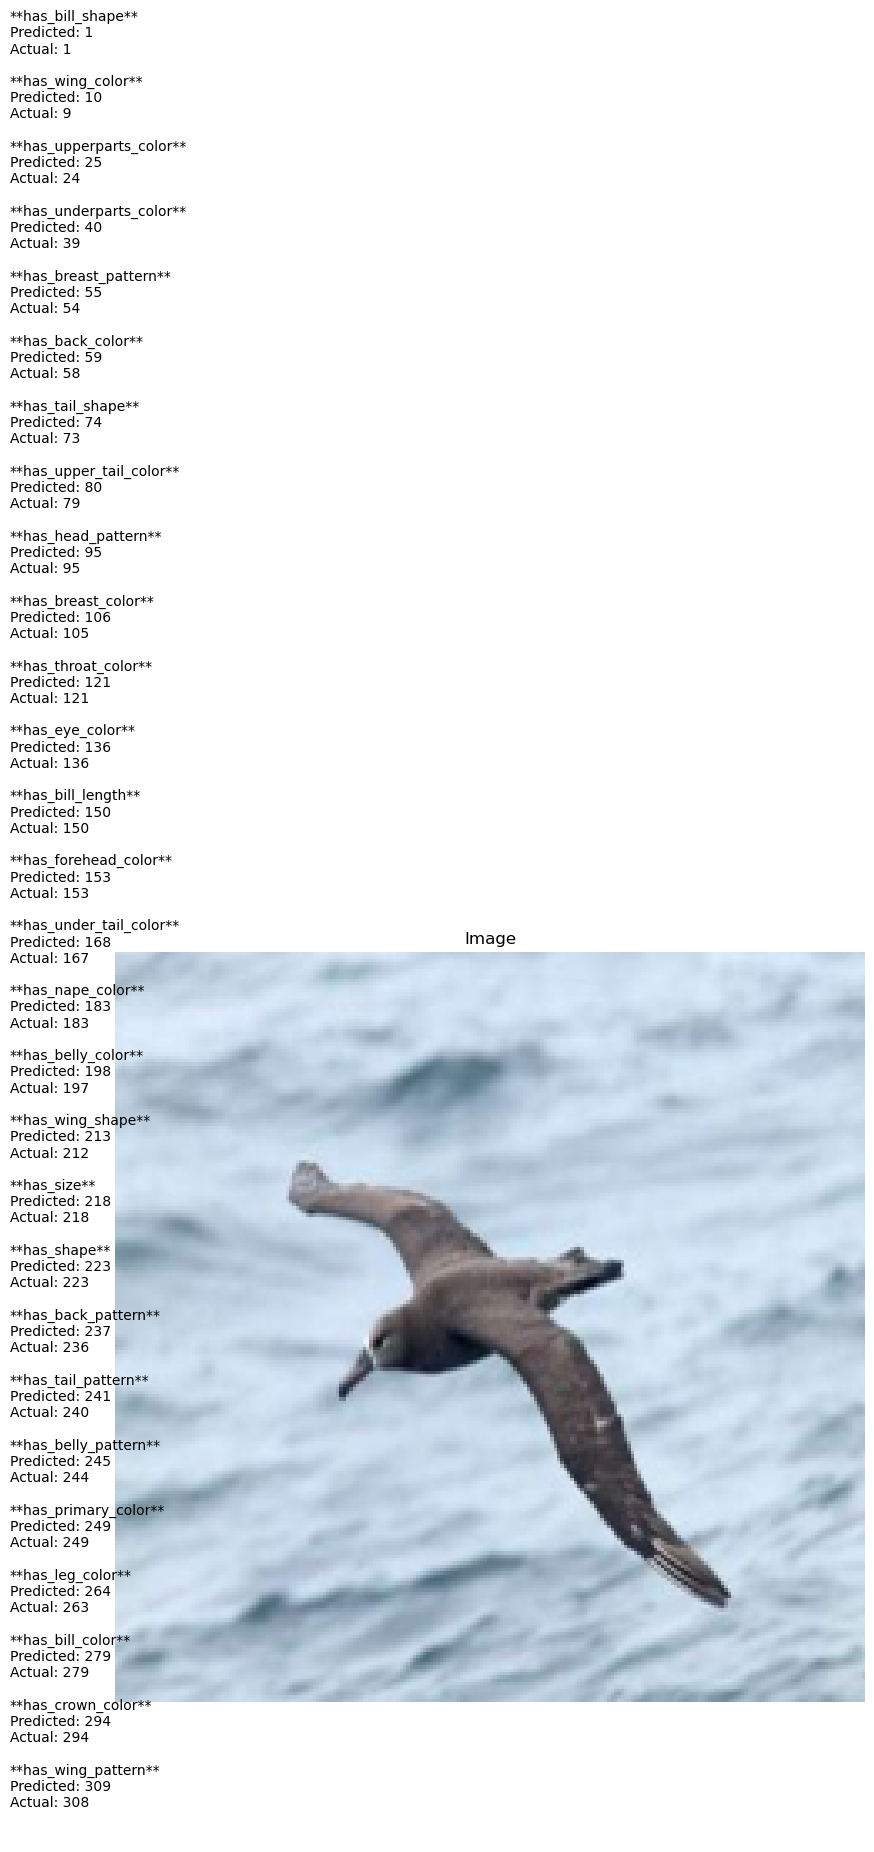

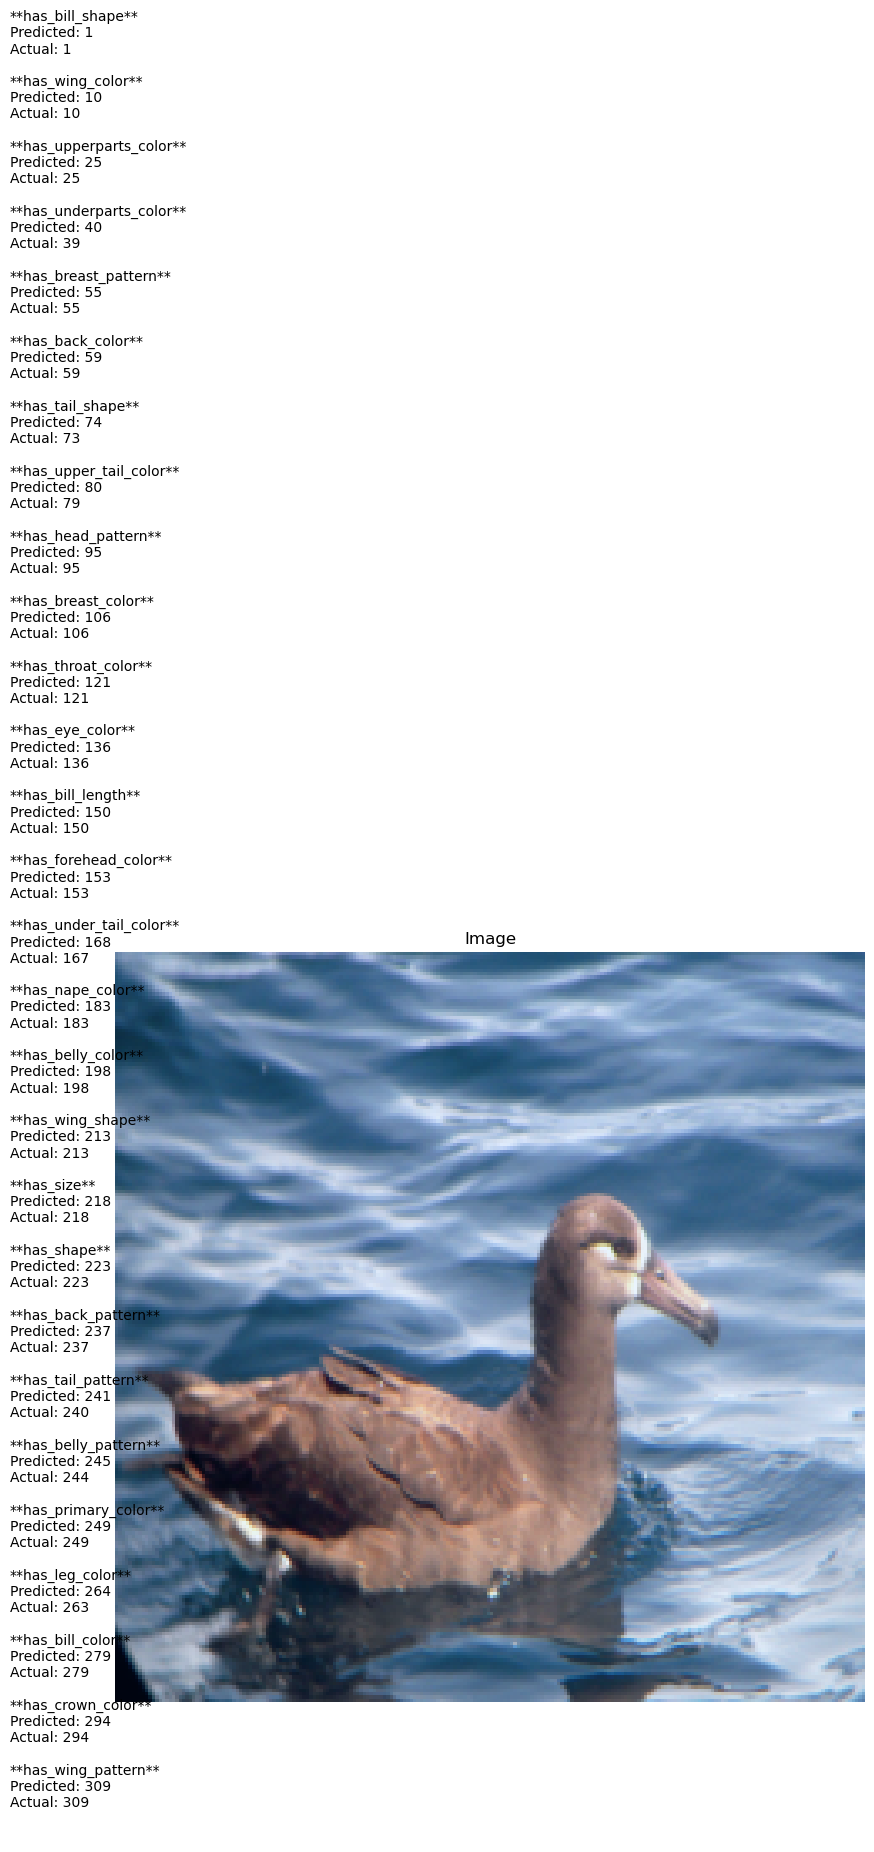

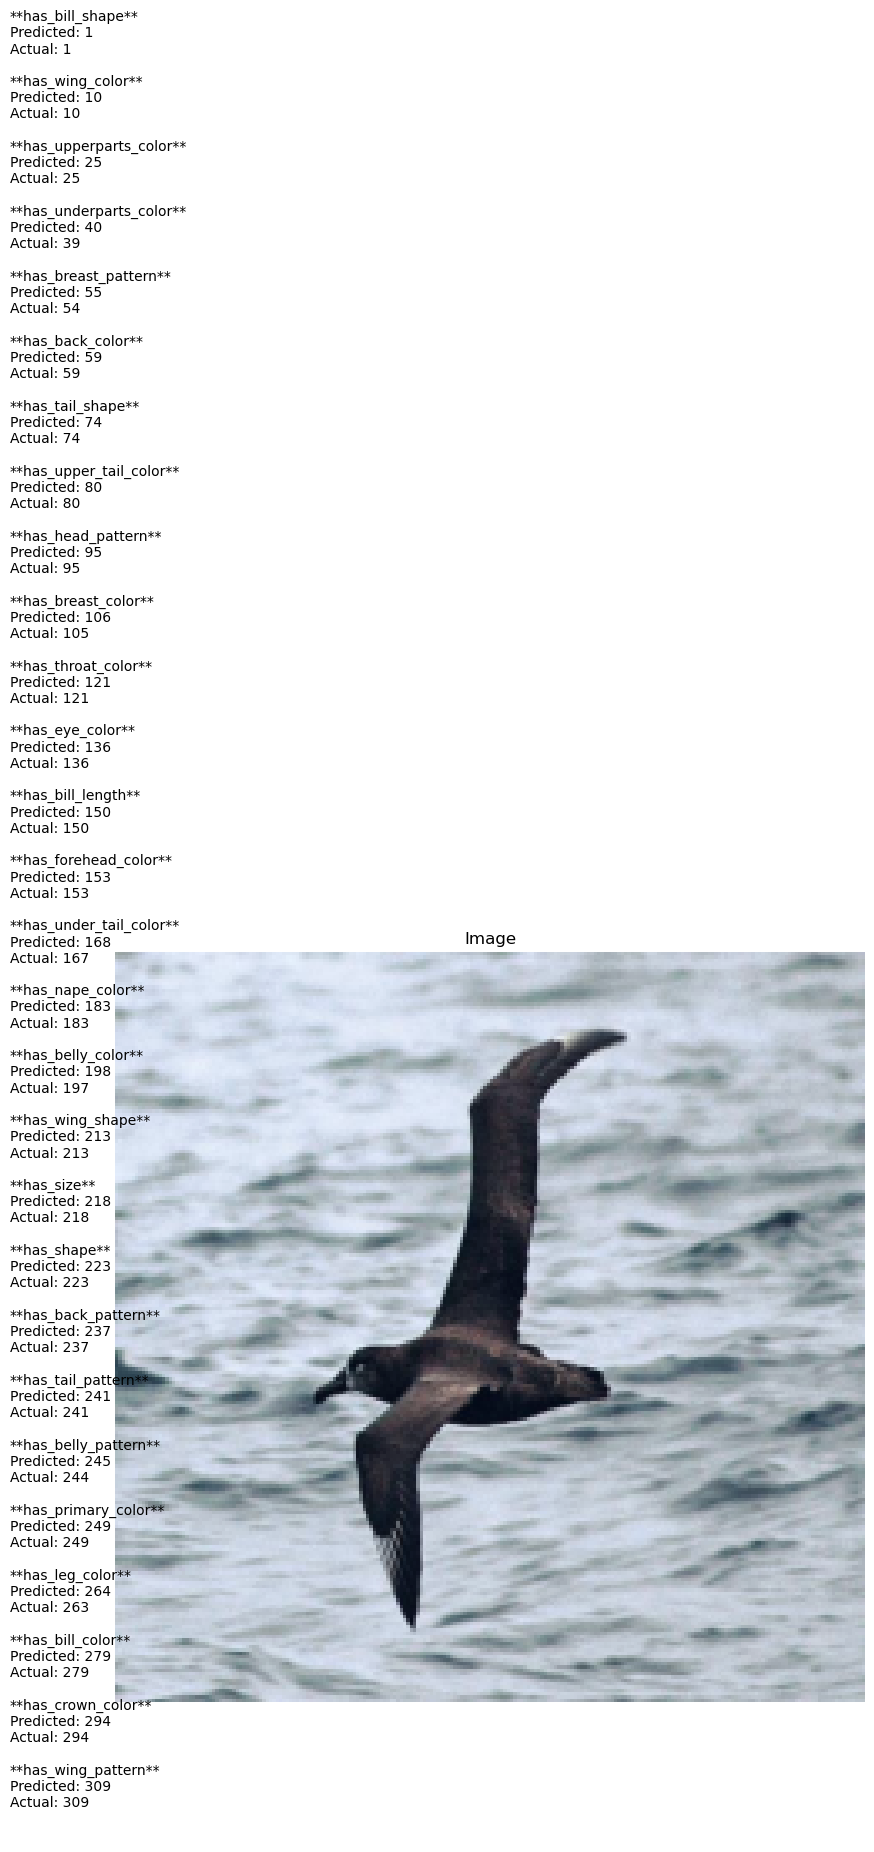

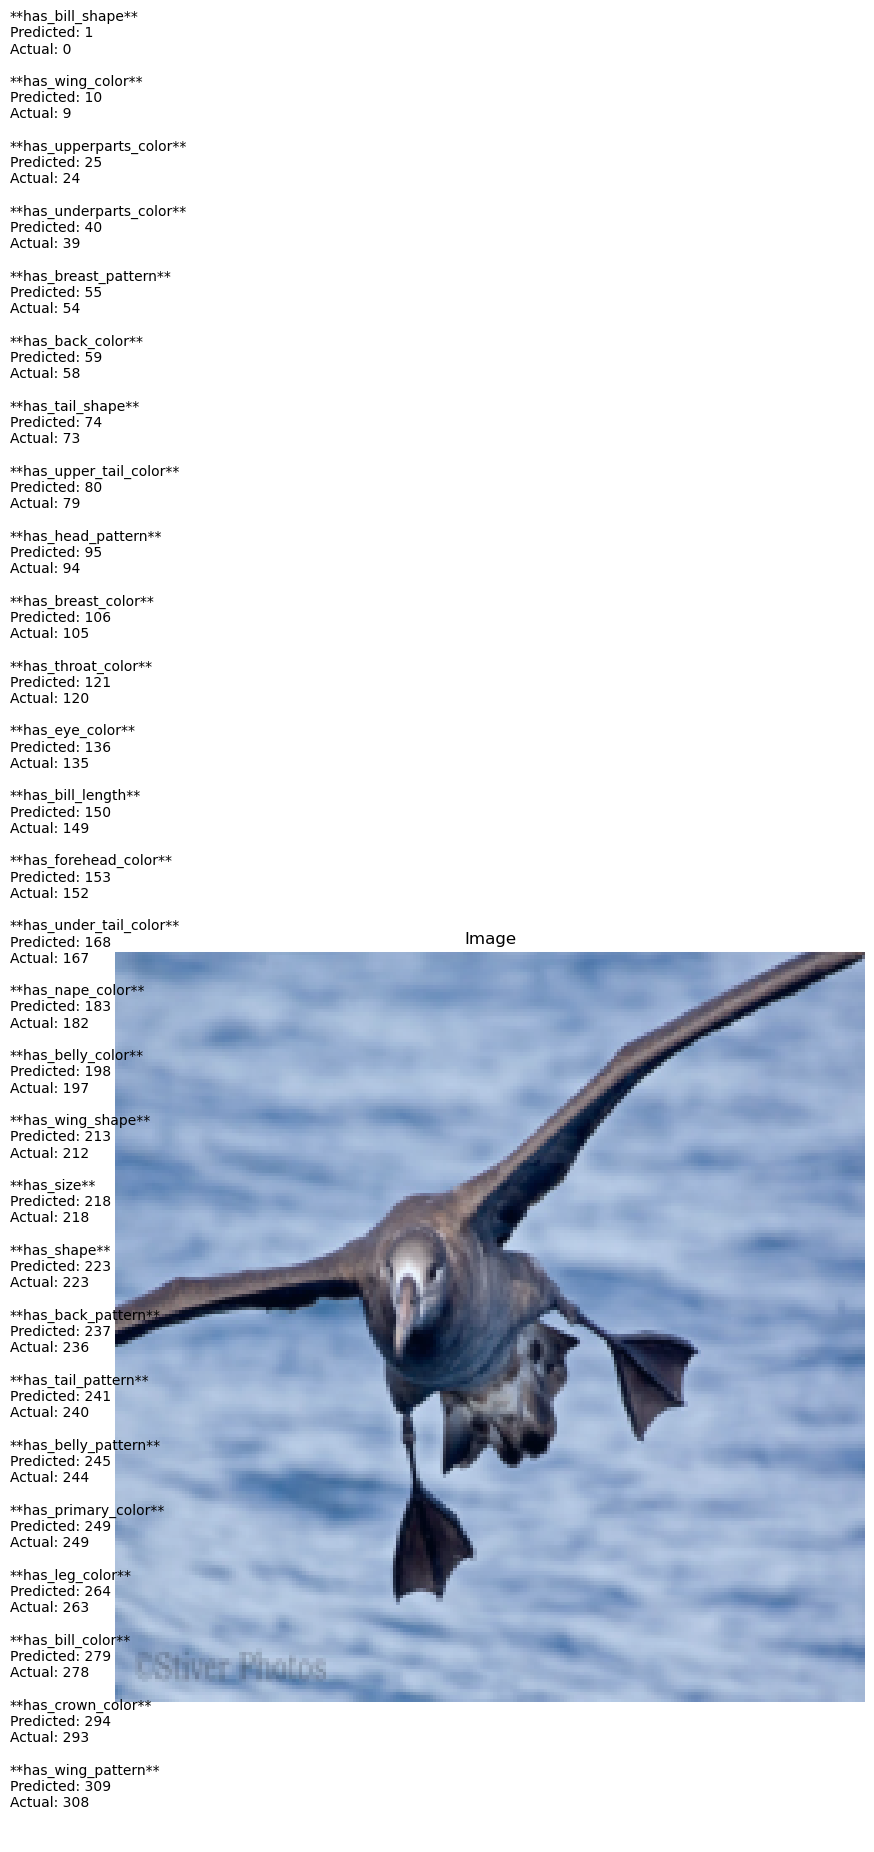

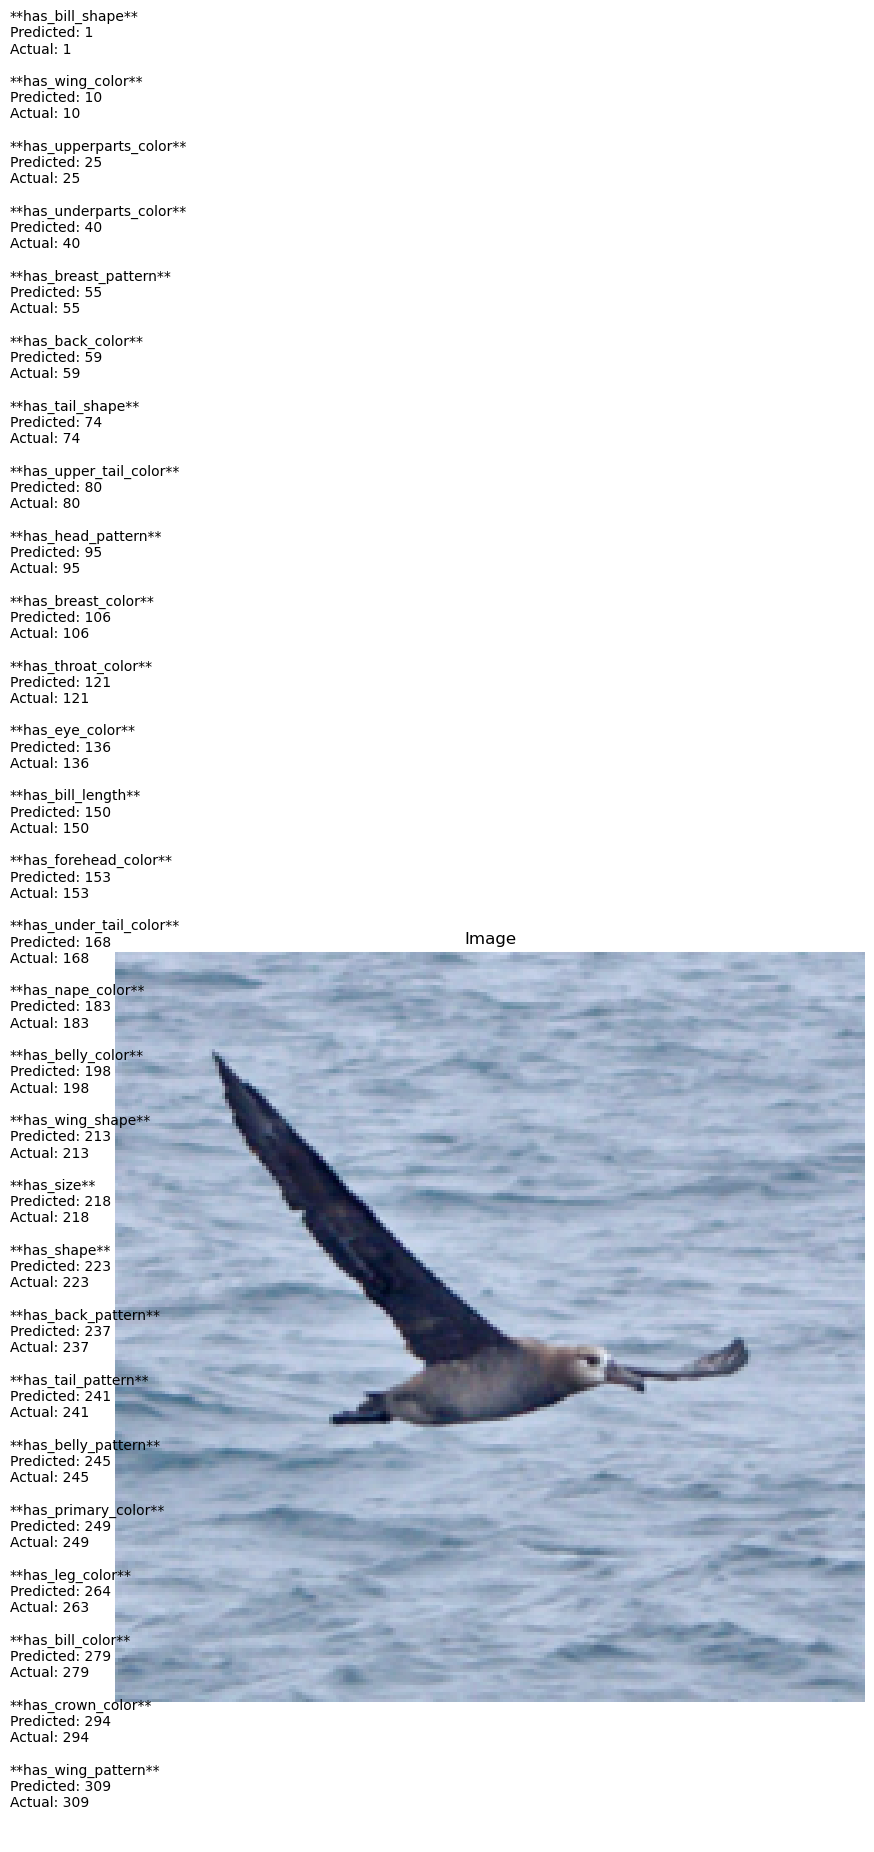

In [28]:
visualize_predictions(model, test_loader, attribute_groups, num_samples=5)


In [29]:
# Access the first batch of test_loader
for images, labels in test_loader:
    for i in range(5):
        print(f"Image {i+1} labels:")
        for group_name, group_labels in labels.items():
            print(f"  {group_name}: {group_labels[i].cpu().numpy()}")
    break  # Only process the first batch


Image 1 labels:
  has_bill_shape: [0. 1. 0. 0. 0. 0. 0. 0. 0.]
  has_wing_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_upperparts_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_underparts_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_breast_pattern: [1. 0. 0. 0.]
  has_back_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_tail_shape: [1. 0. 0. 0. 0. 0.]
  has_upper_tail_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_head_pattern: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_breast_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_throat_color: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_eye_color: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_bill_length: [0. 1. 0.]
  has_forehead_color: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_under_tail_color: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_nape_color: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  has_belly_color: [1. 0. 0. 0. 0. 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define Dataset
class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.labels = np.loadtxt(label_file, dtype=int)
        self.attribute_groups = attribute_groups
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Extract integer labels for each group
        labels = {group: self.labels[idx, min(indices):max(indices) + 1].argmax()
                  for group, indices in self.attribute_groups.items()}
        return image, labels

# Define the Model
class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.group_classifiers = nn.ModuleDict({
            group_name: nn.Linear(in_features, len(indices))
            for group_name, indices in attribute_groups.items()
        })

    def forward(self, x):
        features = self.resnet(x)
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.group_classifiers.items()
        }
        return outputs

# Attribute Groups
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54, 58)),
    "has_back_color": list(range(58, 73)),
    "has_tail_shape": list(range(73, 79)),
    "has_upper_tail_color": list(range(79, 94)),
    "has_head_pattern": list(range(94, 105)),
    "has_breast_color": list(range(105, 120)),
    "has_throat_color": list(range(120, 135)),
    "has_eye_color": list(range(135, 149)),
    "has_bill_length": list(range(149, 152)),
    "has_forehead_color": list(range(152, 167)),
    "has_under_tail_color": list(range(167, 182)),
    "has_nape_color": list(range(182, 197)),
    "has_belly_color": list(range(197, 212)),
    "has_wing_shape": list(range(212, 217)),
    "has_size": list(range(217, 222)),
    "has_shape": list(range(222, 236)),
    "has_back_pattern": list(range(236, 240)),
    "has_tail_pattern": list(range(240, 244)),
    "has_belly_pattern": list(range(244, 248)),
    "has_primary_color": list(range(248, 263)),
    "has_leg_color": list(range(263, 278)),
    "has_bill_color": list(range(278, 293)),
    "has_crown_color": list(range(293, 308)),
    "has_wing_pattern": list(range(308, 312)),
}

# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.001
image_size = (224, 224)

# Paths
train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"

# Transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and Dataloader
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, transform)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, and Optimizer
model = ResNetGroupedMultiClass(attribute_groups).to(device)
criterion = {group: nn.CrossEntropyLoss() for group in attribute_groups.keys()}
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Function
def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = {group: 0 for group in attribute_groups.keys()}
        total_samples = {group: 0 for group in attribute_groups.keys()}

        for images, labels in train_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}

            optimizer.zero_grad()
            outputs = model(images)
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            for group in outputs:
                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

        # Calculate epoch accuracy
        total_accuracy = sum(correct_predictions[group] for group in correct_predictions) / sum(total_samples[group] for group in total_samples)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Total Accuracy: {total_accuracy:.4f}")

# Evaluation Function
def evaluate_grouped_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)

            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()

                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

    # Calculate overall accuracy
    total_accuracy = sum(correct_predictions[group] for group in correct_predictions) / sum(total_samples[group] for group in total_samples)
    print(f"Total Loss: {total_loss:.4f}, Total Accuracy: {total_accuracy:.4f}")

# Training and Evaluation
train_grouped_model(model, train_loader, criterion, optimizer, epochs=epochs)
evaluate_grouped_model(model, test_loader, criterion)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [13]:
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54))
}

print(attribute_groups)

for value in attribute_groups.values():
  print(value)
  for i in value:
    print(i)

{'has_bill_shape': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'has_wing_color': [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'has_upperparts_color': [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], 'has_underparts_color': [39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]}
[0, 1, 2, 3, 4, 5, 6, 7, 8]
0
1
2
3
4
5
6
7
8
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
